In [79]:
# Imports
%matplotlib notebook

import csv
from collections import defaultdict
import itertools as it
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pingouin as pg
from pycountry import languages
import seaborn as sns
from tqdm import tqdm

In [80]:
### LOAD CLASSIFIER & DATASET STATISTICS

# Parsed log files with classifier accuracy stats
logs = pd.read_csv("../data/logstats_rf_072020.csv")

# Get proper language names
def parse_language(name):
    lang = name.split(".")[0]
    if lang.startswith("task1"):
        lang = lang.split("-")[-1]
    elif "_" in lang:
        lang = lang.split("_")[0]
    return languages.lookup(lang).name
    
logs["language"] = [parse_language(s) for s in logs["file"]]
logs.reset_index()

# Get dataset statistics (Type-token ratios, training set size, etc.)
# & merge with log stats
stats = pd.read_csv("../data/datastats_plus.csv")
stats = pd.merge(logs, stats, on=["dataset", "file"])

# Parsed log files with classifier stats w/o morph. features
logs_nomorph = pd.read_csv("../data/logstats_rf_nomorph_072020.csv")
logs_nomorph["language"] = [parse_language(s) for s in logs_nomorph["file"]]
logs_nomorph.reset_index()

stats = pd.merge(logs_nomorph, stats, on=["dataset", "file"], suffixes=('_nomorph', ''))
stats["diff_f1_morph_nomorph"] = stats["clf_f1"] - stats["clf_f1_nomorph"]
stats["clf_f1_by_bor"] = stats["clf_f1"] * (1.0 - stats["bor"])

ISO_CODES = {}
def get_iso_code(name):
    global ISO_CODES
    if name not in ISO_CODES:
        lang = languages.lookup(name)
        ISO_CODES[name] = lang.alpha_3.upper()
    return ISO_CODES[name]

stats["alpha_3"] = stats["language"].apply(get_iso_code)

stats.columns

Index(['dataset', 'file', 'clf_acc_nomorph', 'clf_f1_nomorph',
       'clf_mcc_nomorph', 'clf_kappa_nomorph', 'diff_acc_nomorph',
       'diff_f1_nomorph', 'language_nomorph', 'clf_acc', 'clf_f1', 'clf_mcc',
       'clf_kappa', 'diff_acc', 'diff_f1', 'language', 'ttr', 'bor', 'feats',
       'ftr', 'train_sents', 'train_toks', 'diff_f1_morph_nomorph',
       'clf_f1_by_bor', 'alpha_3'],
      dtype='object')

In [81]:
dataset_latex = {
    "conll2009": "\\taskSEM{}",
    "conll2018": "\\taskUD{}",
    "parseme2018": "\\taskPARSEME{}",
    "wmt19-qe": "\\taskQE{}",
}
dataset_defs = [
    r"\newcommand{\taskSEM}{\textsc{sem}}",
    r"\newcommand{\taskUD}{\textsc{udp}}",
    r"\newcommand{\taskPARSEME}{\textsc{vmwe}}",
    r"\newcommand{\taskQE}{\textsc{mt}}"
]
mpl.rcParams["pgf.preamble"] = "\n".join(dataset_defs)

stats["dataset_latex"] = stats["dataset"].map(dataset_latex)

In [82]:
### LOAD MORPH. COMPLEXITY STATS

mlc_dtypes = defaultdict(lambda: float)
mlc_dtypes["fname"] = str
mlc = pd.read_csv("../data/mlcstats.tsv", sep="\t", dtype=mlc_dtypes)
mlc["language"] = [languages.lookup(lang).name if lang not in ("qhe",) else lang for lang in mlc["fname"]]
stats = stats.join(mlc.set_index("language"), on="language", lsuffix="stats")

mlc.columns

Index(['fname', 'ttr', 'ttr_sd', 'msp', 'msp_sd', 'pos_ent', 'pos_ent_sd',
       'pos_types', 'pos_types_sd', 'feat_ent', 'feat_ent_sd', 'feat_types',
       'feat_types_sd', 'cent_form_feat', 'cent_form_feat_sd',
       'cent_feat_form', 'cent_feat_form_sd', 'language'],
      dtype='object')

In [83]:
### LOAD FEATURE STATISTICS & IMPORTANCES

def classify_feature(fname):
    if fname.startswith("freq") or fname.startswith("len"):
        return "control"
    if fname.startswith("tok:"):
        return "token"
    return "universal"

def keyify_feature(fname):
    for key in ("freq", "len", "edit"):
        if fname.startswith(key):
            return key
    if fname.startswith("tok:"):
        return fname.split("=")[0]
    if fname[0] in ("+", "-", "^"):
        return fname[1:]
    return fname

def get_feat_df(dirname):
    feat_dict = defaultdict(list)
    for i, row in logs.iterrows():
        filename = row["file"].replace(".conllu.gz", ".tsv").replace(".conll.gz", ".tsv")
        with open(f"{dirname}/{row['dataset']}/{filename}", 'r', newline='') as f:
            r = csv.DictReader(f, delimiter="\t")
            for line in r:
                feat_dict["file"].append(row["file"])
                feat_dict["language"].append(row["language"])
                feat_dict["alpha_3"].append(get_iso_code(row["language"]))
                feat_dict["dataset"].append(row["dataset"])
                feat_dict["feature_name"].append(line["feature_name"])
                feat_dict["feature_class"].append(classify_feature(line["feature_name"]))
                feat_dict["feature_key"].append(keyify_feature(line["feature_name"]))
                feat_dict["phi_corrcoef"].append(float(line["phi_corrcoef"]))
                feat_dict["phi_pvalue"].append(float(line["phi_pvalue"]))
                feat_dict["feature_count"].append(int(line["feat_count"]))
                feat_dict["feature_importance"].append(float(line["feature_importance"]))
                feat_dict["feature_importance_signed"].append(
                    float(line["feature_importance"]) * np.sign(float(line["phi_corrcoef"]))
                )
                feat_dict["correlates_with"].append(line["x_correlates_with"])
                feat_dict["rank"].append(int(line["feat_rank"] if line["feat_rank"] else 999))

    return pd.DataFrame.from_dict(feat_dict)

feat_df = get_feat_df("../data/analyzed_rf")
feat_df_nomorph = get_feat_df("../data/analyzed_rf_nomorph")


In [84]:
feat_df.columns

Index(['file', 'language', 'alpha_3', 'dataset', 'feature_name',
       'feature_class', 'feature_key', 'phi_corrcoef', 'phi_pvalue',
       'feature_count', 'feature_importance', 'feature_importance_signed',
       'correlates_with', 'rank'],
      dtype='object')

In [85]:
feat_df_nomorph.columns

Index(['file', 'language', 'alpha_3', 'dataset', 'feature_name',
       'feature_class', 'feature_key', 'phi_corrcoef', 'phi_pvalue',
       'feature_count', 'feature_importance', 'feature_importance_signed',
       'correlates_with', 'rank'],
      dtype='object')

In [87]:
# Define some sub-dataframes & other variables that are frequently re-used

stats_conll2018 = stats[stats["dataset"] == "conll2018"]
stats_conll2009 = stats[stats["dataset"] == "conll2009"]
stats_parseme = stats[stats["dataset"] == "parseme2018"]
stats_wmt = stats[stats["dataset"] == "wmt19-qe"]

control_features = set(n for n in feat_df["feature_name"] if n.startswith("freq") or n.startswith("len"))
universal_features = set(n for n in feat_df["feature_name"] if not (n.startswith("tok:") or n.startswith("freq") or n.startswith("len")))
token_features = set(n for n in feat_df["feature_name"] if n.startswith("tok:"))

feat_conll2018 = feat_df.set_index("dataset").filter(like="conll2018", axis=0)
feat_conll2018_univ = feat_conll2018[
    feat_conll2018.apply(lambda x: x["feature_name"] in universal_features, axis=1)
]

In [88]:
len(stats_conll2018["language"].unique())

57

In [89]:
len(stats["language"].unique())

57

# Classifier performance on the "ERROR" class

<IPython.core.display.Javascript object>


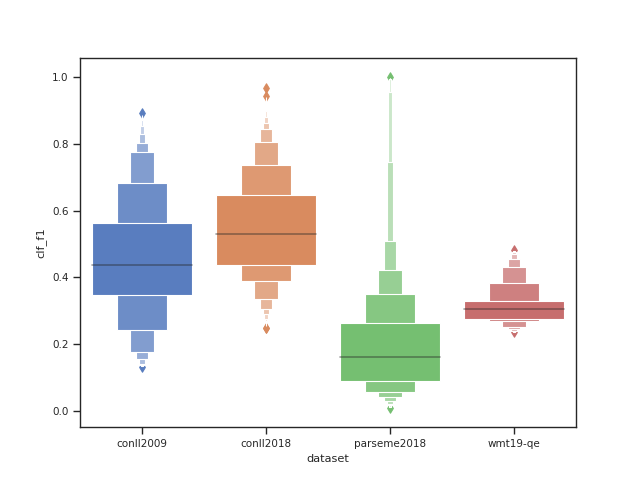

In [44]:
# Quantiles of F-scores for ERROR class prediction, by dataset

sns.boxenplot(data=logs, x="dataset", y="clf_f1")

<IPython.core.display.Javascript object>


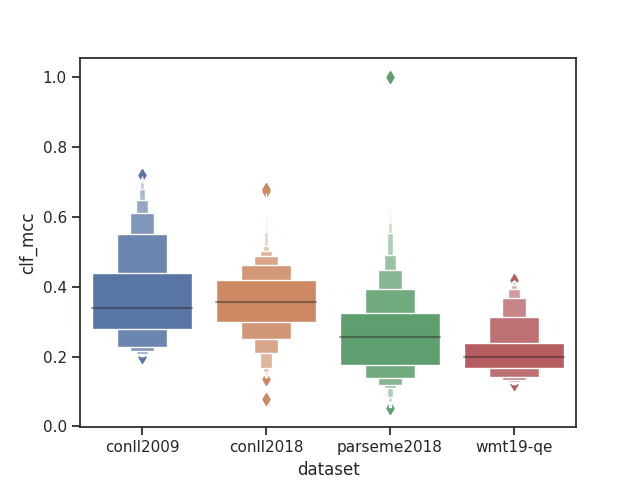

In [15]:
# What about MCC?

sns.boxenplot(data=logs, x="dataset", y="clf_mcc")

## By dataset and language

<IPython.core.display.Javascript object>


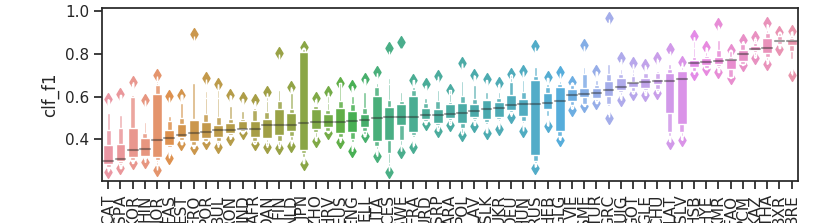

In [90]:
conll2018_clf_f1_means = {}
for lang in set(stats_conll2018["alpha_3"]):
    lang_clf = stats_conll2018[stats_conll2018["alpha_3"] == lang]["clf_f1"]
    conll2018_clf_f1_means[lang] = lang_clf.median()

sns.boxenplot(
    data=stats_conll2018,
    x="alpha_3",
    y="clf_f1",
    order=sorted(conll2018_clf_f1_means.keys(), key=lambda x: conll2018_clf_f1_means[x])
)
plt.xticks(rotation=90)
plt.tight_layout()

<IPython.core.display.Javascript object>


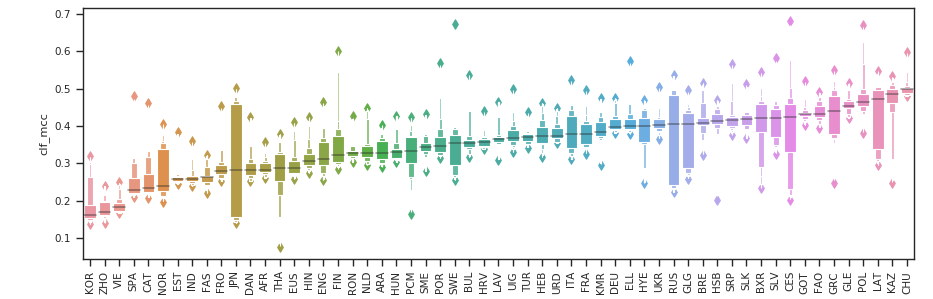

In [61]:
conll2018_clf_mcc_means = {}
for lang in set(stats_conll2018["alpha_3"]):
    lang_clf = stats_conll2018[stats_conll2018["alpha_3"] == lang]["clf_mcc"]
    conll2018_clf_mcc_means[lang] = lang_clf.median()

sns.boxenplot(
    data=stats_conll2018,
    x="alpha_3",
    y="clf_mcc",
    order=sorted(conll2018_clf_mcc_means.keys(), key=lambda x: conll2018_clf_mcc_means[x])
)
plt.xticks(rotation=90)
plt.tight_layout()

<IPython.core.display.Javascript object>


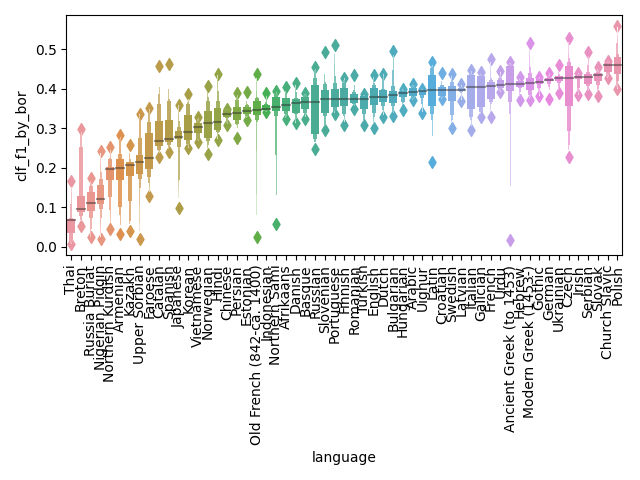

In [10]:
#stats_conll2018["clf_f1_by_bor"] = stats_conll2018["clf_f1"] * (1.0 - stats_conll2018["bor"])
conll2018_clf_f1_by_bor_means = {}
for lang in set(stats_conll2018["language"]):
    lang_clf = stats_conll2018[stats_conll2018["language"] == lang]["clf_f1_by_bor"]
    conll2018_clf_f1_by_bor_means[lang] = lang_clf.median()

sns.boxenplot(
    data=stats_conll2018,
    x="language",
    y="clf_f1_by_bor",
    order=sorted(conll2018_clf_f1_by_bor_means.keys(), key=lambda x: conll2018_clf_f1_by_bor_means[x])
)
plt.xticks(rotation=90)
plt.tight_layout()

<IPython.core.display.Javascript object>


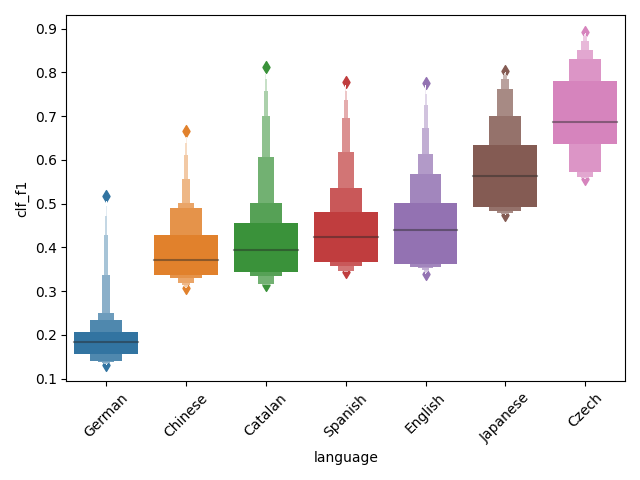

In [15]:
conll2009_clf_f1_means = {}
for lang in set(stats_conll2009["language"]):
    lang_clf = stats_conll2009[stats_conll2009["language"] == lang]["clf_f1"]
    conll2009_clf_f1_means[lang] = lang_clf.median()

sns.boxenplot(
    data=stats_conll2009,
    x="language",
    y="clf_f1",
    order=sorted(conll2009_clf_f1_means.keys(), key=lambda x: conll2009_clf_f1_means[x])
)
plt.xticks(rotation=45)
plt.tight_layout()

<IPython.core.display.Javascript object>


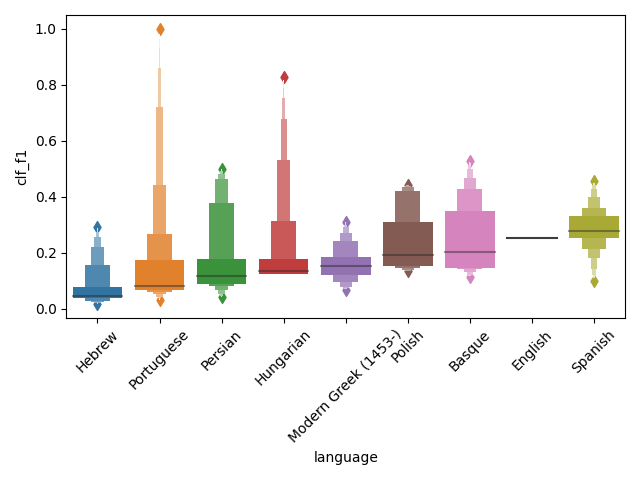

In [16]:
parseme_clf_f1_means = {}
for lang in set(stats_parseme["language"]):
    lang_clf = stats_parseme[stats_parseme["language"] == lang]["clf_f1"]
    parseme_clf_f1_means[lang] = lang_clf.median()

sns.boxenplot(
    data=stats_parseme,
    x="language",
    y="clf_f1",
    order=sorted(parseme_clf_f1_means.keys(), key=lambda x: parseme_clf_f1_means[x])
)
plt.xticks(rotation=45)
plt.tight_layout()

## Correlation with dataset statistics

The following plot suggests that classifier performance correlates strongly with frequency of the "BAD" class, i.e., the performance of the original shared task model when measured by simple accuracy:

<IPython.core.display.Javascript object>


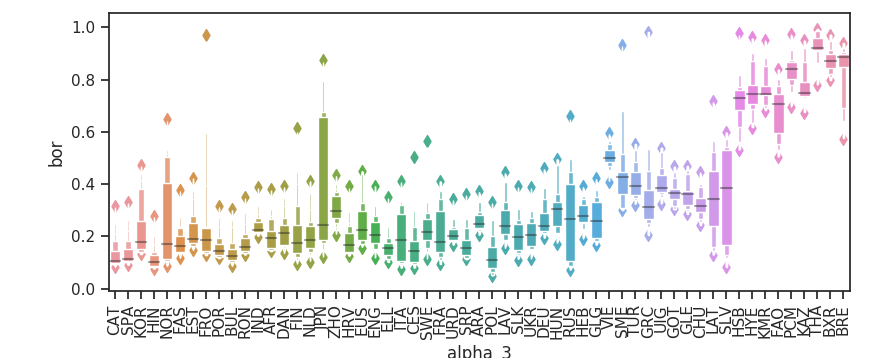

In [20]:
sns.boxenplot(
    data=stats_conll2018,
    x="alpha_3",
    y="bor",
    order=sorted(conll2018_clf_f1_means.keys(), key=lambda x: conll2018_clf_f1_means[x])
)
plt.xticks(rotation=90)
plt.tight_layout()

<IPython.core.display.Javascript object>


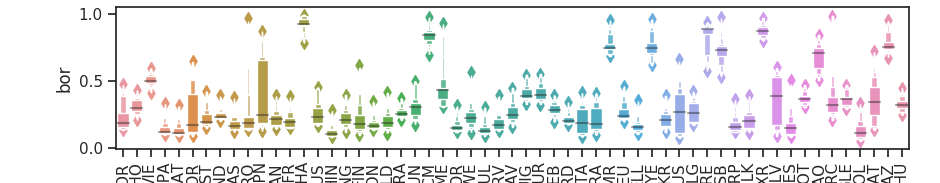

In [21]:
# But MCC, not so much ...

sns.boxenplot(
    data=stats_conll2018,
    x="alpha_3",
    y="bor",
    order=sorted(conll2018_clf_mcc_means.keys(), key=lambda x: conll2018_clf_mcc_means[x])
)
plt.xticks(rotation=90)
plt.tight_layout()

In [22]:
correlate = lambda x, y: stats_conll2018[[x, y]].corr(method="pearson").loc[x].loc[y]

print("Correlation of BAD-class F1-score")
print(f"with frequency of BAD label:  {correlate('clf_f1', 'bor'):+.4f}")
print(f"with type-token ratio (TTR):  {correlate('clf_f1', 'ttr'):+.4f}")
print(f"with no. of morph features:   {correlate('clf_f1', 'feats'):+.4f}")
print(f"with TTR of morph features:   {correlate('clf_f1', 'ftr'):+.4f}")
print(f"with size of training data:   {correlate('clf_f1', 'train_toks'):+.4f}")


Correlation of BAD-class F1-score
with frequency of BAD label:  +0.8906
with type-token ratio (TTR):  +0.1695
with no. of morph features:   -0.0154
with TTR of morph features:   +0.3605
with size of training data:   -0.2479


For comparison, here are the outputs for logistic regression:

```
Correlation of BAD-class F1-score
with frequency of BAD label:  +0.9316
with type-token ratio (TTR):  +0.0617
with no. of morph features:   -0.1461
with TTR of morph features:   +0.3463
with size of training data:   -0.2878
```

In [23]:
correlate = lambda x, y: stats_conll2018[[x, y]].corr(method="pearson").loc[x].loc[y]

print("Correlation of Matthews Correlation Coefficient")
print(f"with frequency of BAD label:  {correlate('clf_mcc', 'bor'):+.4f}")
print(f"with type-token ratio (TTR):  {correlate('clf_mcc', 'ttr'):+.4f}")
print(f"with no. of morph features:   {correlate('clf_mcc', 'feats'):+.4f}")
print(f"with TTR of morph features:   {correlate('clf_mcc', 'ftr'):+.4f}")
print(f"with size of training data:   {correlate('clf_mcc', 'train_toks'):+.4f}")


Correlation of Matthews Correlation Coefficient
with frequency of BAD label:  +0.2736
with type-token ratio (TTR):  +0.2242
with no. of morph features:   +0.3576
with TTR of morph features:   +0.0426
with size of training data:   -0.0084


<IPython.core.display.Javascript object>


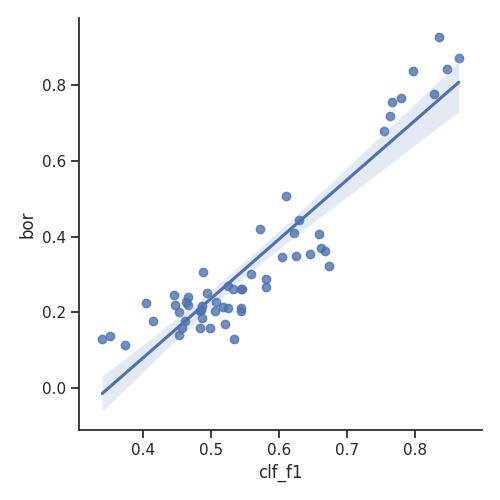

In [24]:
ax = sns.lmplot(
    data=stats_conll2018.groupby("language").mean(),
    x="clf_f1",
    y="bor",
    legend_out=True,
)
plt.tight_layout()
ax = plt.gca()

### Uncomment these to annotate the language codes
#for language, l_stats in stats_conll2018.groupby("language").mean()[["clf_f1", "bor"]].iterrows():
#    language = languages.lookup(language).alpha_3
#    ax.annotate(language, (l_stats["clf_f1"], l_stats["bor"]), (l_stats["clf_f1"] + 0.0, l_stats["bor"] - 0.02))


<IPython.core.display.Javascript object>


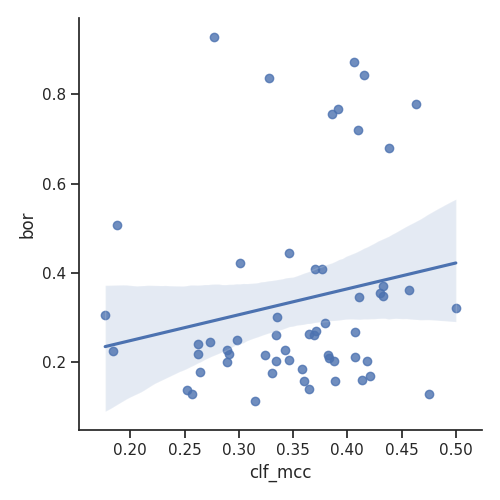

In [25]:
ax = sns.lmplot(
    data=stats_conll2018.groupby("language").mean(),
    x="clf_mcc",
    y="bor",
    legend_out=True,
)
plt.tight_layout()
ax = plt.gca()

In [20]:
pg.partial_corr(
    data=stats_conll2018,
    x='clf_f1',
    y='bor',
    covar='train_toks'
)

,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,2016,0.883027,"[0.87, 0.89]",0.779737,0.779518,0.0,inf,1.0


In [21]:
pg.pairwise_corr(
    data=stats_conll2018,
    columns=["clf_f1"]
)

,X,Y,method,tail,n,r,CI95%,r2,adj_r2,z,p-unc,BF10,power
0,clf_f1,clf_acc_nomorph,pearson,two-sided,2016,0.136158,"[0.09, 0.18]",0.018539,0.017564,0.137009,8.341690e-10,4.183e+06,0.999986
1,clf_f1,clf_f1_nomorph,pearson,two-sided,2016,0.897541,"[0.89, 0.91]",0.805579,0.805386,1.459424,0.000000e+00,inf,1.000000
2,clf_f1,diff_acc_nomorph,pearson,two-sided,2016,0.519259,"[0.49, 0.55]",0.269630,0.268904,0.575325,1.323336e-139,5.27e+135,1.000000
3,clf_f1,diff_f1_nomorph,pearson,two-sided,2016,-0.689815,"[-0.71, -0.67]",0.475845,0.475324,-0.847603,8.075206e-285,4.671e+280,1.000000
4,clf_f1,clf_acc,pearson,two-sided,2016,0.310153,"[0.27, 0.35]",0.096195,0.095297,0.320715,3.337980e-46,4.312e+42,1.000000
5,clf_f1,diff_acc,pearson,two-sided,2016,0.661448,"[0.64, 0.69]",0.437514,0.436955,0.795384,6.187754e-254,6.821e+249,1.000000
6,clf_f1,diff_f1,pearson,two-sided,2016,-0.514926,"[-0.55, -0.48]",0.265149,0.264419,-0.569411,6.310397e-137,1.121e+133,1.000000
7,clf_f1,ttr,pearson,two-sided,2016,0.169459,"[0.13, 0.21]",0.028717,0.027752,0.171110,1.867290e-14,1.499e+11,1.000000
8,clf_f1,bor,pearson,two-sided,2016,0.890634,"[0.88, 0.9]",0.793229,0.793023,1.424984,0.000000e+00,inf,1.000000
9,clf_f1,feats,pearson,two-sided,2016,-0.015447,"[-0.06, 0.03]",0.000239,-0.000755,-0.015448,4.881896e-01,0.035,0.106609


### Some stats for ALL datasets

In [45]:
correlate = lambda x, y: stats[[x, y]].corr(method="pearson").loc[x].loc[y]

print("Correlation of BAD-class F1-score")
print(f"with frequency of BAD label:  {correlate('clf_f1', 'bor'):+.4f}")
print(f"with type-token ratio (TTR):  {correlate('clf_f1', 'ttr'):+.4f}")
print(f"with no. of morph features:   {correlate('clf_f1', 'feats'):+.4f}")
print(f"with TTR of morph features:   {correlate('clf_f1', 'ftr'):+.4f}")
print(f"with size of training data:   {correlate('clf_f1', 'train_toks'):+.4f}")


Correlation of BAD-class F1-score
with frequency of BAD label:  +0.8704
with type-token ratio (TTR):  +0.2248
with no. of morph features:   -0.0779
with TTR of morph features:   +0.3482
with size of training data:   -0.2479


In [155]:
correlate('diff_f1_morph_nomorph', 'bor')

-0.11970535403090449

In [154]:
correlate('clf_mcc', 'bor')

0.3001166519731463

In [156]:
correlate('feat_ent', 'bor')

-0.13196899184346134

<IPython.core.display.Javascript object>


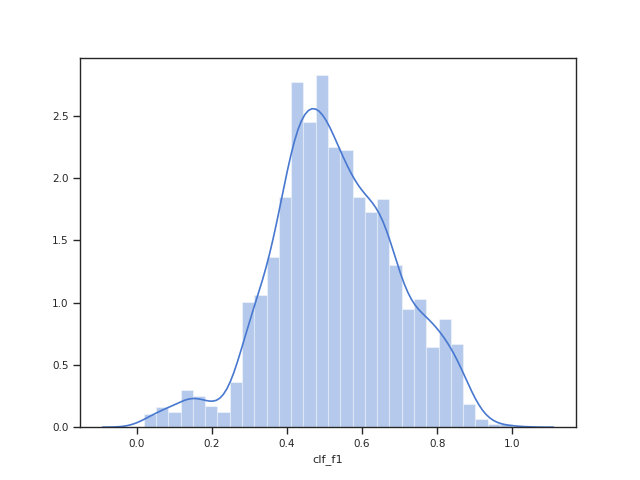

In [49]:
sns.distplot(stats["clf_f1"])

In [50]:
stats["clf_f1"].mean()

0.52594288217258

In [51]:
stats["clf_f1"].std()

0.1653801825808112

In [52]:
stats["clf_mcc"].mean(), stats["clf_mcc"].std()

(0.3522378449408673, 0.09675125435462024)

<IPython.core.display.Javascript object>


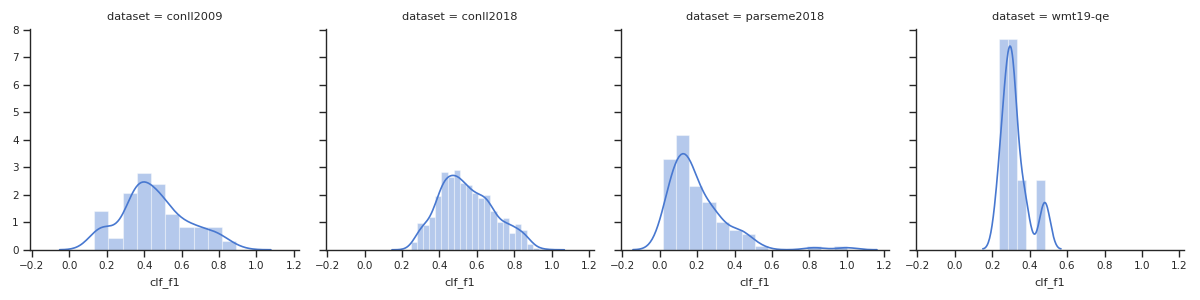

In [53]:
g = sns.FacetGrid(stats, col="dataset", margin_titles=True)
g.map(sns.distplot, "clf_f1")

<IPython.core.display.Javascript object>


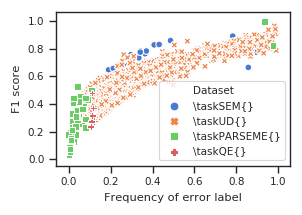

In [55]:
# Quantiles of F-scores for ERROR class prediction, by dataset

stats["Dataset"] = stats["dataset_latex"]
sns.set_context("paper", font_scale=.85)
sns.set_style("ticks")
sns.set_palette("muted")
plt.figure(figsize=(3.02, 2.15))
sns.scatterplot(stats["bor"], stats["clf_f1"],
                hue=stats["Dataset"],
                style=stats["Dataset"],
                #alpha=0.6
               )
g = plt.gca()
g.set_ylabel("F1 score")
g.set_xlabel("Frequency of error label")
#g.set_xticklabels(["CoNLL'09", "CoNLL'18", "PARSEME'18", "WMT'19-QE"])
#g.set_xticklabels(["SRL", "UDP", "V-MWE", "QE"])
#g.get_legend().get_children()

plt.tight_layout()
#mpl.rcParams["pgf.preamble"] = "\n".join(dataset_defs)
if True:
    plt.savefig('plots/fscore_vs_bor.pgf', bbox_inches='tight')
    

## What if we take away the morphological features?

Classifiers runs with only `freq` and `len` features:

In [57]:
logs["feature_set"] = "Full"
logs_nomorph["feature_set"] = "Control only"
logs_cat = pd.concat([logs, logs_nomorph])

<IPython.core.display.Javascript object>


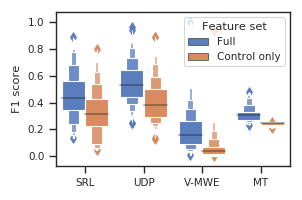

In [58]:
# Quantiles of F-scores for ERROR class prediction, by dataset

sns.set_context("paper", font_scale=.85)
sns.set_style("ticks")
sns.set_palette("muted")
plt.figure(figsize=(3.02, 2.0))
sns.boxenplot(data=logs_cat, x="dataset", y="clf_f1", hue="feature_set")
g = plt.gca()
g.set_ylabel("F1 score")
g.set_xlabel("")
#g.set_xticklabels(["CoNLL'09", "CoNLL'18", "PARSEME'18", "WMT'19-QE"])
g.set_xticklabels(["SRL", "UDP", "V-MWE", "MT"])
#g.get_legend().set_title("Feature set")

handles, labels = g.get_legend_handles_labels()
g.legend(handles, labels, loc="upper right", title="Feature set")

plt.tight_layout()
#plt.gcf().set_size_inches(w=3.02, h=2.0)
if True:
    plt.savefig('plots/fscore_by_morph.pgf', bbox_inches='tight')

<IPython.core.display.Javascript object>


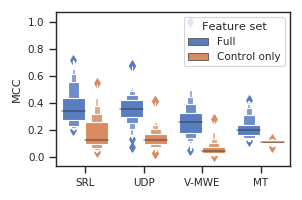

In [157]:
# Same but with Matthews

sns.set_context("paper", font_scale=.85)
sns.set_style("ticks")
sns.set_palette("muted")
plt.figure(figsize=(3.02, 2.0))
sns.boxenplot(data=logs_cat, x="dataset", y="clf_mcc", hue="feature_set")
g = plt.gca()
g.set_ylabel("MCC")
g.set_xlabel("")
#g.set_xticklabels(["CoNLL'09", "CoNLL'18", "PARSEME'18", "WMT'19-QE"])
g.set_xticklabels(["SRL", "UDP", "V-MWE", "MT"])
#g.get_legend().set_title("Feature set")

handles, labels = g.get_legend_handles_labels()
g.legend(handles, labels, loc="upper right", title="Feature set")

plt.tight_layout()
#plt.gcf().set_size_inches(w=3.02, h=2.0)
#if True:
#    plt.savefig('plots/mcc_by_morph.pgf', bbox_inches='tight')

<IPython.core.display.Javascript object>


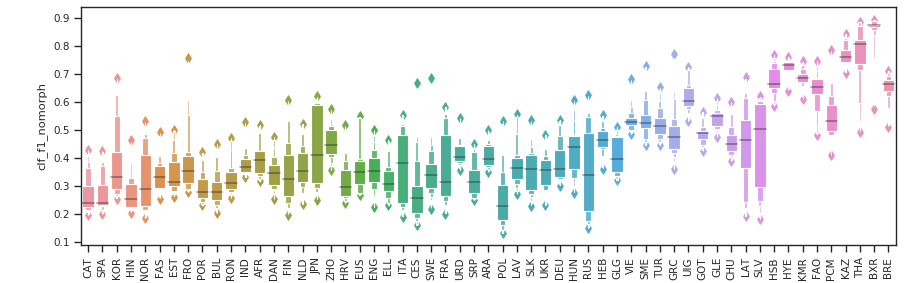

In [60]:
sns.set_style("ticks")
sns.boxenplot(
    data=stats_conll2018,
    x="alpha_3",
    y="clf_f1_nomorph",
    order=sorted(conll2018_clf_f1_means.keys(), key=lambda x: conll2018_clf_f1_means[x])
)
plt.xticks(rotation=90)
plt.tight_layout()

<IPython.core.display.Javascript object>


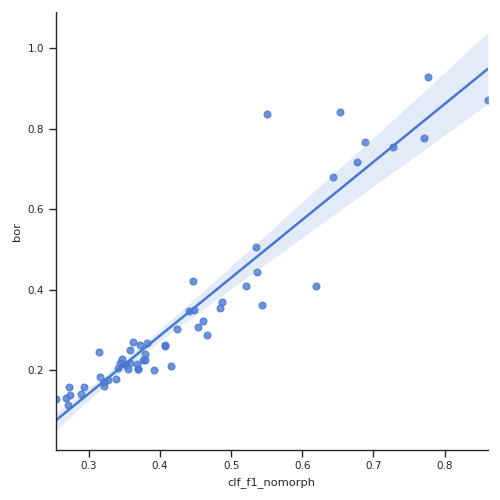

In [28]:
ax = sns.lmplot(
    data=stats_conll2018.groupby("language").mean(),
    x="clf_f1_nomorph",
    y="bor",
    legend_out=True,
)
plt.tight_layout()

## Are morphological features more important for some languages?

In [126]:
_blues = sns.color_palette("Blues")
_cmap = sns.blend_palette([_blues[2], _blues[-1]], as_cmap=True)

mfe_sorted = sorted(
    stats_conll2018["alpha_3"].unique(),
    key=lambda x: stats_conll2018.groupby("alpha_3")["diff_f1_morph_nomorph"].median().loc[x].item()
)
_urgh = stats_conll2018.set_index("alpha_3").loc[mfe_sorted]["feat_ent"]
mfe_sorted = [_urgh[x][0] for x in mfe_sorted]
mfe_min = min(mfe_sorted)
mfe_max = max(mfe_sorted)

_colors = [_cmap((x - mfe_min) / mfe_max) 
           if not np.isnan(x)
           else (0.7,0.7,0.7,1.0)
           for x in mfe_sorted]

<IPython.core.display.Javascript object>


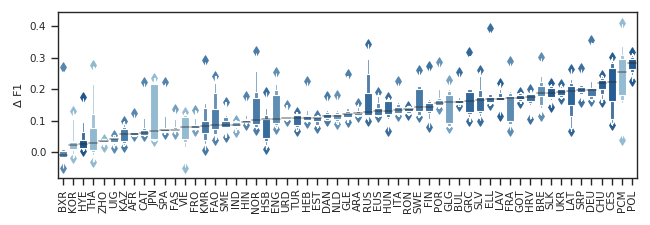

In [127]:
sns.set_context("paper", font_scale=.85)
plt.figure(figsize=(6.5, 2.25))
sns.boxenplot(
    data=stats_conll2018,
    x="alpha_3",
    y="diff_f1_morph_nomorph",
    order=sorted(
        stats_conll2018["alpha_3"].unique(),
        key=lambda x: stats_conll2018.groupby("alpha_3")["diff_f1_morph_nomorph"].median().loc[x].item()
    ),
    palette=_colors
)
plt.xticks(rotation=90)
g = plt.gca()
g.set_ylabel(r"$\Delta$ F1")
#g.set_xlabel("Language")
g.set_xlabel(None)
plt.tight_layout()
if True:
    plt.savefig('plots/fscore_delta_by_lang.pgf', bbox_inches='tight')

<IPython.core.display.Javascript object>


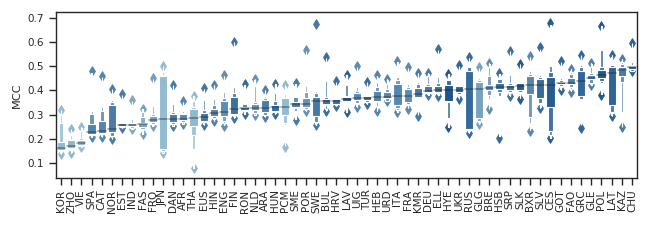

In [153]:
_blues = sns.color_palette("Blues")
_cmap = sns.blend_palette([_blues[2], _blues[-1]], as_cmap=True)

mfe_sorted = sorted(
    stats_conll2018["alpha_3"].unique(),
    key=lambda x: stats_conll2018.groupby("alpha_3")["clf_mcc"].median().loc[x].item()
)
_urgh = stats_conll2018.set_index("alpha_3").loc[mfe_sorted]["feat_ent"]
mfe_sorted = [_urgh[x][0] for x in mfe_sorted]
mfe_min = min(mfe_sorted)
mfe_max = max(mfe_sorted)

_colors = [_cmap((x - mfe_min) / mfe_max) 
           if not np.isnan(x)
           else (0.7,0.7,0.7,1.0)
           for x in mfe_sorted]
sns.set_context("paper", font_scale=.85)
plt.figure(figsize=(6.5, 2.25))
sns.boxenplot(
    data=stats_conll2018,
    x="alpha_3",
    y="clf_mcc",
    order=sorted(
        stats_conll2018["alpha_3"].unique(),
        key=lambda x: stats_conll2018.groupby("alpha_3")["clf_mcc"].median().loc[x].item()
    ),
    palette=_colors
)
plt.xticks(rotation=90)
g = plt.gca()
g.set_ylabel(r"MCC")
#g.set_xlabel("Language")
g.set_xlabel(None)
plt.tight_layout()
if True:
    plt.savefig('plots/mcc_by_lang.pgf', bbox_inches='tight')

In [102]:
stats_conll2018.groupby("alpha_3")["diff_f1_morph_nomorph"].median()["POL"]

0.2847

In [31]:
control_importance = feat_conll2018[
    feat_conll2018.apply(lambda x: x["feature_name"] in control_features, axis=1)
]
__tmp = control_importance.groupby("file")["feature_importance"].sum().reset_index()
__tmp["language"] = control_importance.groupby("file")["language"].first().reset_index()["language"]
control_importance = __tmp
control_importance["alpha_3"] = control_importance["language"].apply(get_iso_code)

morph_importance = feat_conll2018[
    feat_conll2018.apply(lambda x: x["feature_name"] not in control_features, axis=1)
]
__tmp = morph_importance.groupby("file")["feature_importance"].sum().reset_index()
__tmp["language"] = morph_importance.groupby("file")["language"].first().reset_index()["language"]
morph_importance = __tmp
morph_importance["alpha_3"] = morph_importance["language"].apply(get_iso_code)

In [32]:
control_morph_diff = pd.DataFrame({
    'language': control_importance["language"],
    'alpha_3': control_importance["alpha_3"],
    'feature_importance': morph_importance["feature_importance"] - control_importance["feature_importance"],
})
control_morph_diff_sort = control_morph_diff.groupby("language").median()

<IPython.core.display.Javascript object>


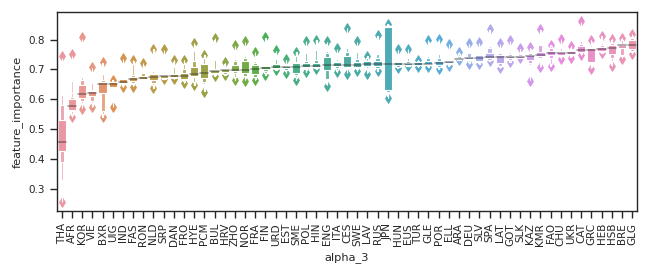

In [33]:
sns.set_context("paper", font_scale=.85)
plt.figure(figsize=(6.5, 2.75))
sns.boxenplot(
    #data=control_morph_diff,
    data=morph_importance,
    x="alpha_3",
    y="feature_importance",
    order=sorted(
        control_morph_diff["alpha_3"].unique(),
        #key=lambda x: control_morph_diff_sort.loc[x].item()
        key=lambda x: morph_importance.groupby("alpha_3")["feature_importance"].median().loc[x].item()
    )
)
plt.xticks(rotation=90)
plt.tight_layout()


Could this be used to argue that morphological features **as a whole set** are more important than the control features?

# Feature importance

<IPython.core.display.Javascript object>


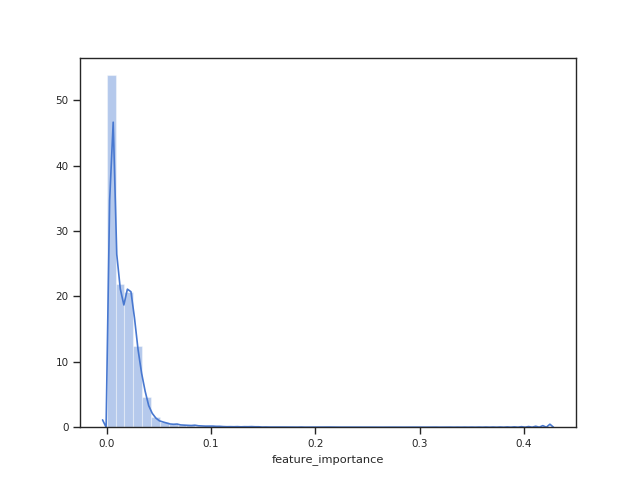

In [216]:
sns.distplot(feat_conll2018["feature_importance"])

In [261]:
feat_conll2018["feature_importance"].mean(), feat_conll2018["feature_importance"].median()

(0.01500507911934144, 0.0101)

<IPython.core.display.Javascript object>


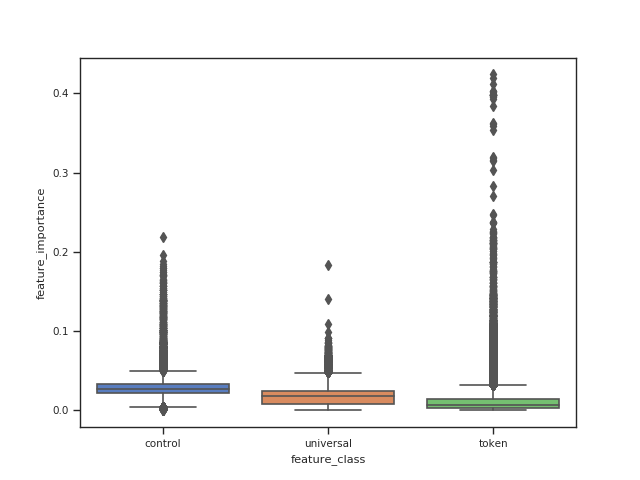

In [266]:
sns.boxplot(
    data=feat_conll2018,
    x="feature_class",
    y="feature_importance"
)

#feat_conll2018.groupby("feature_class")["feature_importance"]

In [25]:
_feature_counts = feat_conll2018.groupby("file")["feature_name"].count()
_feature_counts.max()
#feat_conll2018["feature_importance_normed"] = 
#_fin = (feat_conll2018.set_index("file")["feature_importance"] * _feature_counts).reset_index()[0]
#_fin

296

<IPython.core.display.Javascript object>


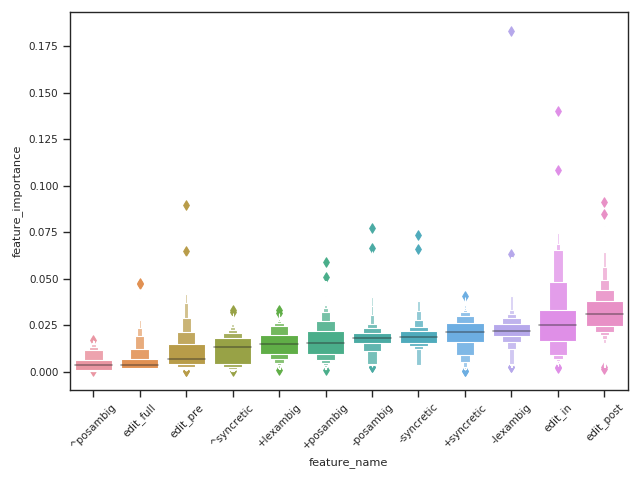

In [214]:
medians = {}
for feat in universal_features:
    feat_score = feat_conll2018_univ[feat_conll2018_univ["feature_name"] == feat]["feature_importance"]
    medians[feat] = feat_score.median()
    
sns.boxenplot(
    data=feat_conll2018_univ,
    x="feature_name",
    y="feature_importance",
    order=sorted(medians.keys(), key=lambda x: medians[x])
)
plt.xticks(rotation=45)
plt.tight_layout()

<IPython.core.display.Javascript object>


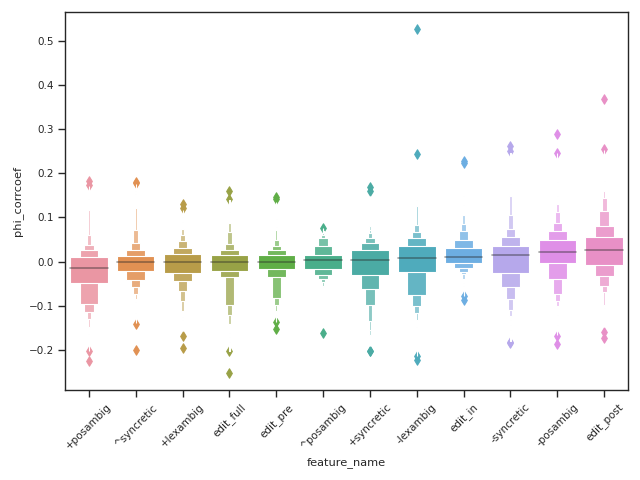

In [128]:
medians = {}
for feat in universal_features:
    feat_score = feat_conll2018_univ[feat_conll2018_univ["feature_name"] == feat]["phi_corrcoef"]
    medians[feat] = feat_score.median()
    
sns.boxenplot(
    data=feat_conll2018_univ,
    x="feature_name",
    y="phi_corrcoef",
    order=sorted(medians.keys(), key=lambda x: medians[x])
)
plt.xticks(rotation=45)
plt.tight_layout()

<IPython.core.display.Javascript object>


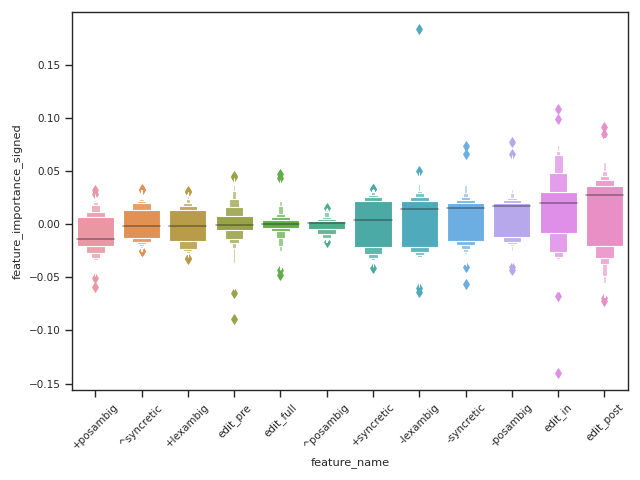

In [36]:
# "feature_importance_signed" is "feature_importance" multiplied by the sign of "phi_corrcoef";
# in other words, negative importance should indicate "important for predicting GOOD class",
# while positive importance should indicate "important for predicting BAD class"

medians = {}
for feat in universal_features:
    feat_score = feat_conll2018_univ[feat_conll2018_univ["feature_name"] == feat]["feature_importance_signed"]
    medians[feat] = feat_score.median()
    
sns.boxenplot(
    data=feat_conll2018_univ,
    x="feature_name",
    y="feature_importance_signed",
    order=sorted(medians.keys(), key=lambda x: medians[x])
)
plt.xticks(rotation=45)
plt.tight_layout()

<IPython.core.display.Javascript object>


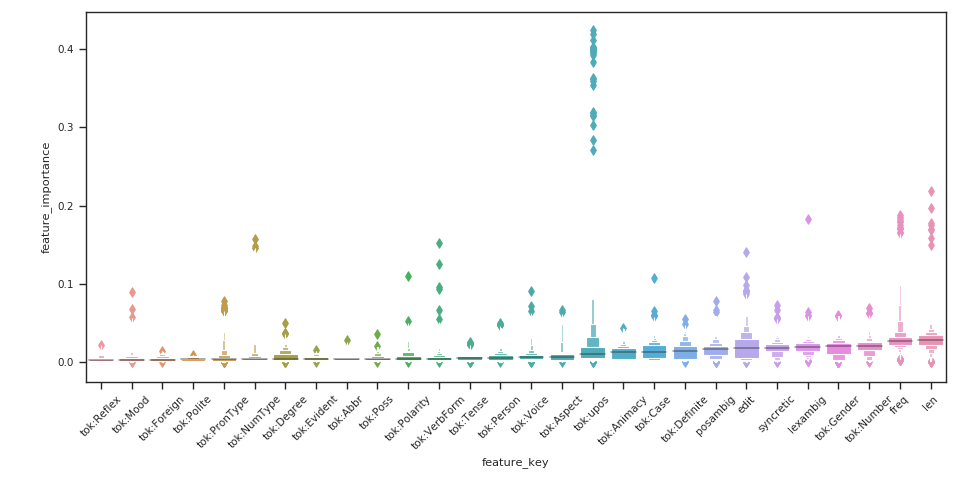

In [321]:
medians = {}
for feat in feat_conll2018["feature_key"].unique():
    feat_score = feat_conll2018[feat_conll2018["feature_key"] == feat]["feature_importance"]
    if not feat_score.empty:
        medians[feat] = feat_score.median()
    
sns.boxenplot(
    data=feat_conll2018,
    x="feature_key",
    y="feature_importance",
    order=sorted(medians.keys(), key=lambda x: medians[x])#[-15:]
)
plt.xticks(rotation=45)
plt.tight_layout()

In [43]:
## Let's look at a table of mean FIs by category

print(feat_conll2018.groupby("feature_key")["feature_importance"].mean().mul(100)
 .sort_values(0, ascending=False).reset_index()[:20].set_index("feature_key").to_latex(float_format="%.2f"))

\begin{tabular}{lr}
\toprule
{} &  feature\_importance \\
feature\_key  &                     \\
\midrule
freq         &                3.01 \\
len          &                2.82 \\
tok:Number   &                1.97 \\
edit         &                1.96 \\
lexambig     &                1.87 \\
tok:Gender   &                1.80 \\
syncretic    &                1.75 \\
tok:upos     &                1.73 \\
posambig     &                1.52 \\
tok:Definite &                1.43 \\
tok:Case     &                1.41 \\
tok:Animacy  &                1.24 \\
tok:Aspect   &                0.76 \\
tok:Voice    &                0.72 \\
tok:Degree   &                0.67 \\
tok:Person   &                0.65 \\
tok:Polarity &                0.60 \\
tok:NumType  &                0.57 \\
tok:PronType &                0.55 \\
tok:Tense    &                0.54 \\
\bottomrule
\end{tabular}



In [126]:
feat_conll2018.columns

Index(['file', 'language', 'alpha_3', 'feature_name', 'feature_class',
       'feature_key', 'phi_corrcoef', 'phi_pvalue', 'feature_count',
       'feature_importance', 'feature_importance_signed', 'correlates_with',
       'rank'],
      dtype='object')

In [141]:
print(feat_conll2018.groupby("feature_name")["phi_corrcoef"].mean()#.mul(100)
      .sort_values(0, ascending=False).reset_index().set_index("feature_name")
      .filter(like="upos", axis=0).to_latex(float_format="%.2f"))

\begin{tabular}{lr}
\toprule
{} &  phi\_corrcoef \\
feature\_name   &               \\
\midrule
tok:upos=NOUN  &          0.08 \\
tok:upos=VERB  &          0.05 \\
tok:upos=X     &          0.04 \\
tok:upos=PROPN &          0.03 \\
tok:upos=SYM   &          0.03 \\
tok:upos=ADV   &          0.03 \\
tok:upos=INTJ  &          0.01 \\
tok:upos=NUM   &          0.01 \\
tok:upos=PRON  &         -0.00 \\
tok:upos=ADJ   &         -0.00 \\
tok:upos=PART  &         -0.00 \\
tok:upos=SCONJ &         -0.01 \\
tok:upos=PUNCT &         -0.01 \\
tok:upos=CCONJ &         -0.01 \\
tok:upos=AUX   &         -0.02 \\
tok:upos=DET   &         -0.07 \\
tok:upos=ADP   &         -0.10 \\
\bottomrule
\end{tabular}



In [67]:
_ffs = feat_conll2018[feat_conll2018["language"] == "German"]

print(_ffs.groupby("feature_key")["feature_importance"].mean().mul(100)
 .sort_values(0, ascending=False).reset_index()[:100].set_index("feature_key").to_latex(float_format="%.2f"))

\begin{tabular}{lr}
\toprule
{} &  feature\_importance \\
feature\_key  &                     \\
\midrule
tok:Gender   &                2.82 \\
tok:Case     &                2.78 \\
len          &                2.71 \\
freq         &                2.52 \\
tok:Number   &                2.09 \\
syncretic    &                2.08 \\
lexambig     &                1.79 \\
edit         &                1.60 \\
posambig     &                1.53 \\
tok:upos     &                1.27 \\
tok:Definite &                0.92 \\
tok:PronType &                0.54 \\
tok:Poss     &                0.53 \\
tok:VerbForm &                0.44 \\
tok:Mood     &                0.44 \\
tok:Tense    &                0.44 \\
tok:Voice    &                0.44 \\
tok:Person   &                0.43 \\
tok:Foreign  &                0.34 \\
tok:NumType  &                0.24 \\
tok:Polarity &                0.18 \\
tok:Reflex   &                0.16 \\
\bottomrule
\end{tabular}



In [97]:
dx = feat_conll2018#[feat_conll2018["language"] == "English"]

dx = dx.reset_index().groupby(["language", "feature_name"]).mean()
#dx = dx[dx["stability_mean_coef"] > 0.1]
dx = dx[dx["phi_corrcoef"] > 0]

#dx.nlargest(10, "stability_score")
dx_langs = sorted(dx.reset_index()["language"].unique())

def nlargest_per_language(n, column):
    nl = []
    for lang in dx_langs:
        dy = dx.loc[lang].nlargest(n, column).reset_index()
        dy["language"] = lang
        nl.append(dy)

    return pd.concat(nl)
        
nlpl = nlargest_per_language(10, "feature_importance").set_index(["language", "feature_name"])
nlpl

phi_corrcoef  phi_pvalue  feature_count  \
language   feature_name                                              
Afrikaans  len4-6              0.122644    0.000000        2055.00   
           edit_post           0.004760    0.415432        1248.80   
           freq=rare           0.103640    0.000000        1567.92   
           freq=p95            0.036392    0.026132         877.96   
           freq=gt3            0.059848    0.000064         923.56   
...                                 ...         ...            ...   
Vietnamese freq=p95            0.038092    0.013532        1398.96   
           freq=rare           0.061408    0.000016         989.04   
           tok:upos=NOUN       0.033188    0.038264        2920.96   
           freq=gt3            0.050780    0.003144        1082.12   
           tok:upos=CCONJ      0.038044    0.005856         314.96   

                           feature_importance  feature_importance_signed  \
language   feature_name                                                    
Afrikaans  len4-6                    0.049072                   0.049072   
           edit_post                 0.041976                   0.027656   
           freq=rare                 0.037728                   0.037728   
           freq=p95                  0.029292                   0.029292   
           freq=gt3                  0.028000                   0.028000   
...                                       ...                        ...   
Vietnamese freq=p95                  0.038404                   0.038404   
           freq=rare                 0.038088                   0.038088   
           tok:upos=NOUN             0.037172                   0.034940   
           freq=gt3                  0.036072                   0.036072   
           tok:upos=CCONJ            0.035992                   0.035992   

                             rank  
language   feature_name            
Afrikaans  len4-6            1.20  
           edit_post       161.64  
           freq=rare         2.84  
           freq=p95          4.88  
           freq=gt3          5.36  
...                           ...  
Vietnamese freq=p95          5.80  
           freq=rare         6.44  
           tok:upos=NOUN    46.08  
           freq=gt3          6.96  
           tok:upos=CCONJ    7.08  

[570 rows x 6 columns]

In [98]:
# In how many languages does a given feature appear in the top 10 most important features?

nlpl.reset_index().groupby(["feature_name"])["language"].count().nlargest(20)

feature_name
freq=rare          53
len4-6             52
freq=p95           45
len7-9             45
freq=p90           42
edit_post          34
freq=gt3           29
tok:Number=Sing    25
tok:upos=NOUN      25
edit_in            24
len10+             17
tok:Gender=Masc    17
tok:Case=Nom       16
freq=p98           14
tok:upos=PUNCT     11
tok:upos=VERB      11
-lexambig          10
-syncretic          7
tok:Gender=Fem      7
+syncretic          6
Name: language, dtype: int64

In [99]:
# What are the MORPHOLOGICAL features with the highest mean feature importance across languages?

dx_count = (
    dx.reset_index().pivot("feature_name", "language", "feature_importance")
    .fillna(0).mean(axis=1).sort_values(ascending=False).reset_index()
)
dx_count

dx_top_feats = dx_count[dx_count.apply(lambda x: x["feature_name"] in token_features, axis=1)]["feature_name"][:20]
dx_top_feats

4         tok:upos=NOUN
9         tok:upos=VERB
11      tok:Number=Sing
13      tok:Number=Plur
14         tok:Case=Nom
15      tok:Gender=Masc
17         tok:upos=ADV
18       tok:upos=PROPN
21         tok:upos=ADJ
22       tok:upos=PUNCT
23       tok:Gender=Fem
25      tok:Gender=Neut
26        tok:upos=PART
27       tok:upos=CCONJ
28         tok:upos=NUM
30         tok:Case=Acc
31        tok:upos=PRON
32         tok:Person=3
33         tok:Case=Dat
35    tok:VerbForm=Part
Name: feature_name, dtype: object

In [118]:
dx = feat_conll2018.groupby("feature_key").mean()["feature_importance"]
dx_top_featkeys = dx.sort_values(ascending=False).reset_index()["feature_key"]

<IPython.core.display.Javascript object>


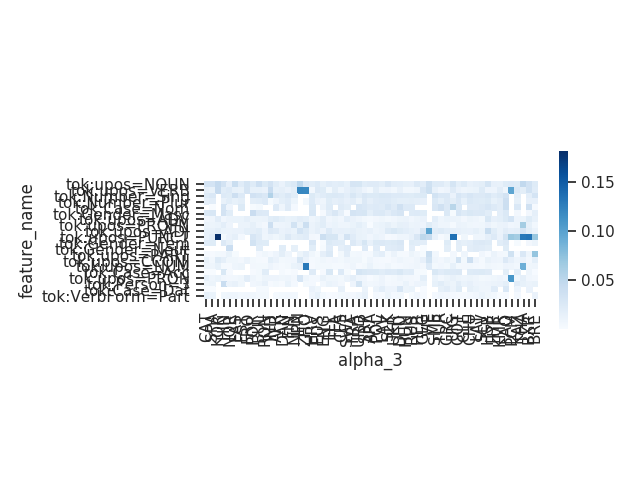

In [120]:
# Plot feature importance (for MORPH. features only), sorting
# - features by average feature importance
# - languages by average classifier performance

plot_variable = "feature_importance"  # can try with "feature_importance_signed" as well

feat_tok_conll2018 = feat_conll2018.apply(lambda x: x ["feature_name"] in set(dx_top_feats), axis=1)
feat_tok_conll2018 = feat_conll2018[feat_tok_conll2018]

dt = feat_tok_conll2018.groupby(["feature_name", "alpha_3"]).mean()[plot_variable].reset_index()
dt_pivot = (
    dt.pivot("feature_name", "alpha_3", plot_variable)
    .reindex(list(dx_top_feats), axis=0)
    .reindex(sorted(conll2018_clf_f1_means.keys(), key=lambda x: conll2018_clf_f1_means[x]), axis=1)
)

sns.heatmap(
    data=dt_pivot,
    cmap="Blues",
    square=True,
    xticklabels=1,
    yticklabels=1,
    cbar_kws=dict(shrink=0.4),
)
plt.tight_layout()

<IPython.core.display.Javascript object>


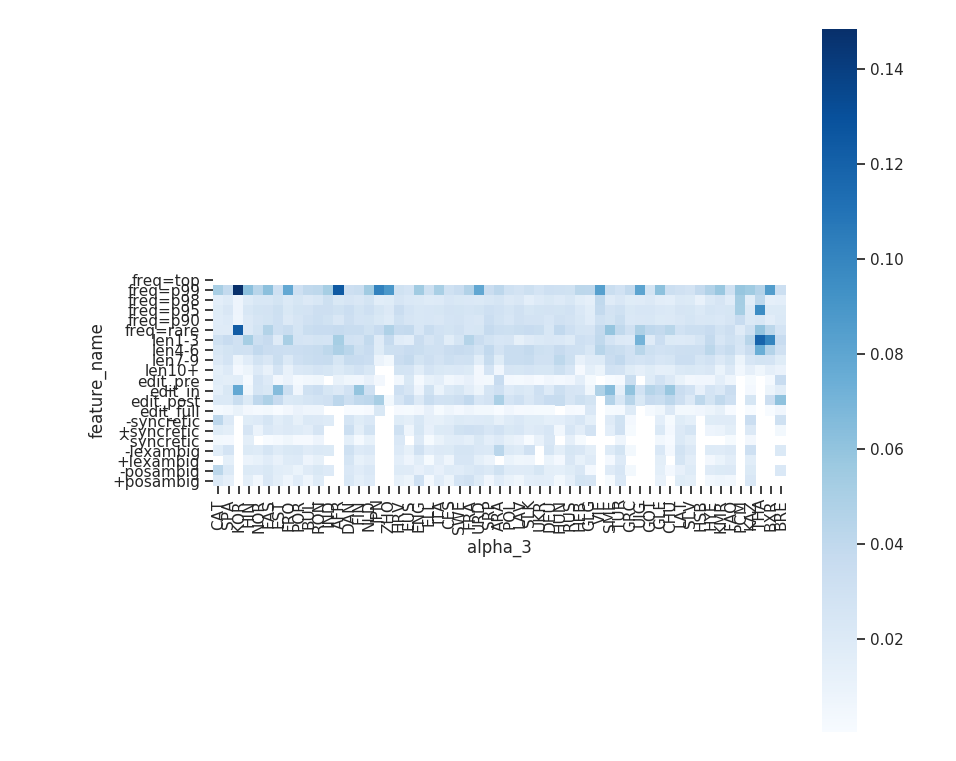

In [102]:
# Plot feature importance (for NON-morph. features only), sorting
# - languages by average classifier performance

plot_variable = "feature_importance"  # can try with "feature_importance_signed" as well

univ_feat_order = [
    "freq=top", "freq=p99", "freq=p98", "freq=p95", "freq=p90", "freq=rare",
    "len1-3", "len4-6", "len7-9", "len10+",
    "edit_pre", "edit_in", "edit_post", "edit_full",
    "-syncretic", "+syncretic", "^syncretic",
    "-lexambig", "+lexambig",
    "-posambig", "+posambig"
]
feat_univ_conll2018 = feat_conll2018.apply(lambda x: x["feature_name"] in univ_feat_order, axis=1)
feat_univ_conll2018 = feat_conll2018[feat_univ_conll2018]

dt = feat_univ_conll2018.groupby(["feature_name", "alpha_3"]).mean()[plot_variable].reset_index()
dt_pivot = (
    dt.pivot("feature_name", "alpha_3", plot_variable)
    .reindex(univ_feat_order, axis=0)
    .reindex(sorted(conll2018_clf_f1_means.keys(), key=lambda x: conll2018_clf_f1_means[x]), axis=1)
)

sns.heatmap(
    data=dt_pivot,
    cmap="Blues",
    square=True,
    xticklabels=1,
    yticklabels=1
)
plt.tight_layout()

<IPython.core.display.Javascript object>


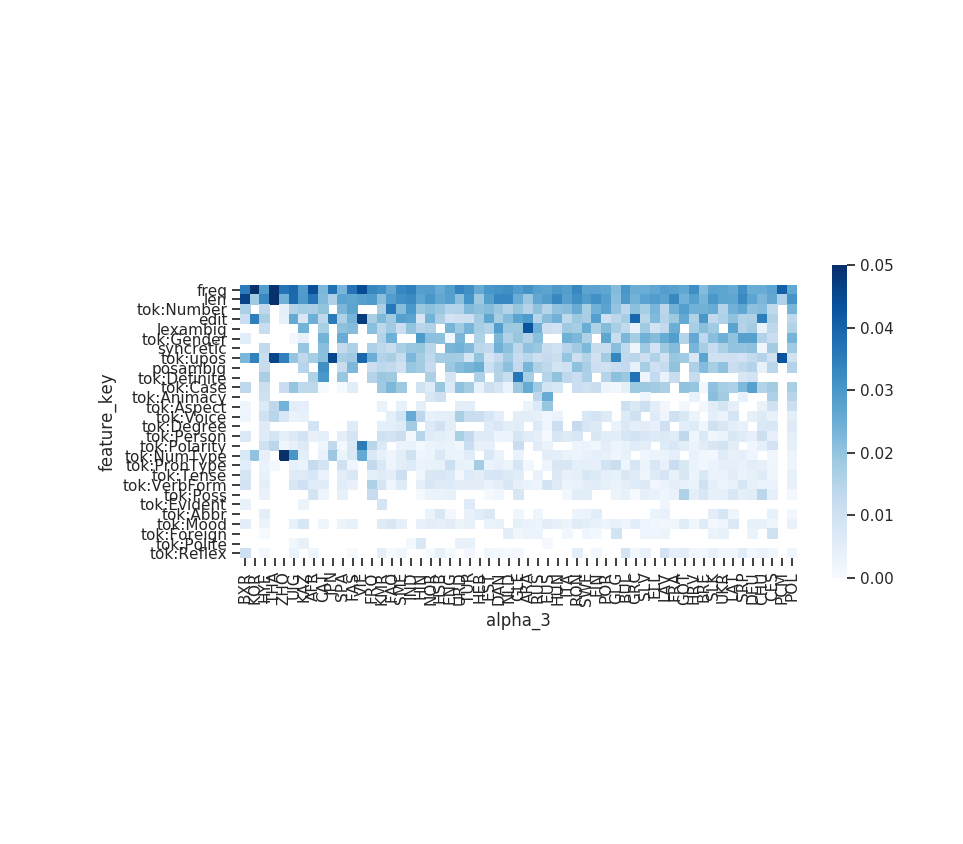

In [124]:
# Plot feature importance BY CATEGORY
# - features by average feature importance
# - languages by average classifier performance

plot_variable = "feature_importance"  # can try with "feature_importance_signed" as well

dt = feat_conll2018.groupby(["feature_key", "alpha_3"])[plot_variable].mean().reset_index()
dt_pivot = (
    dt.pivot("feature_key", "alpha_3", plot_variable)
    .reindex(list(dx_top_featkeys), axis=0)
    .reindex(sorted(
        stats_conll2018["alpha_3"].unique(),
        key=lambda x: stats_conll2018.groupby("alpha_3")["diff_f1_morph_nomorph"].median().loc[x].item()
    ), axis=1)
)
#dt_pivot
sns.heatmap(
    data=dt_pivot,
    cmap="Blues",
    vmin=0,
    vmax=.05,
    square=True,
    xticklabels=1,
    yticklabels=1,
    cbar_kws=dict(shrink=0.4),
)
plt.tight_layout()

## Feature importance, but only for the good classifiers!

It doesn't make sense to include FI for classifiers that haven't learned the task well.  The mean $F_1$ of all classifiers is $0.53$. Let's use a nice, round cutoff of $F_1 > 0.5$.

In [345]:
# FILTER feat_conll2018 BY stats[stats["file"] == feat_conll2018["file"]]["clf_f1"] > 0.5

#feat_conll2018
good_files = stats.query("clf_f1 > 0.5")["file"].unique()
high_mfe = stats.query("feat_ent > 6")["file"].unique()
good_bool  = [(x in good_files and x in high_mfe) for x in feat_conll2018["file"]]
good_feat_conll2018 = feat_conll2018[good_bool]

<IPython.core.display.Javascript object>


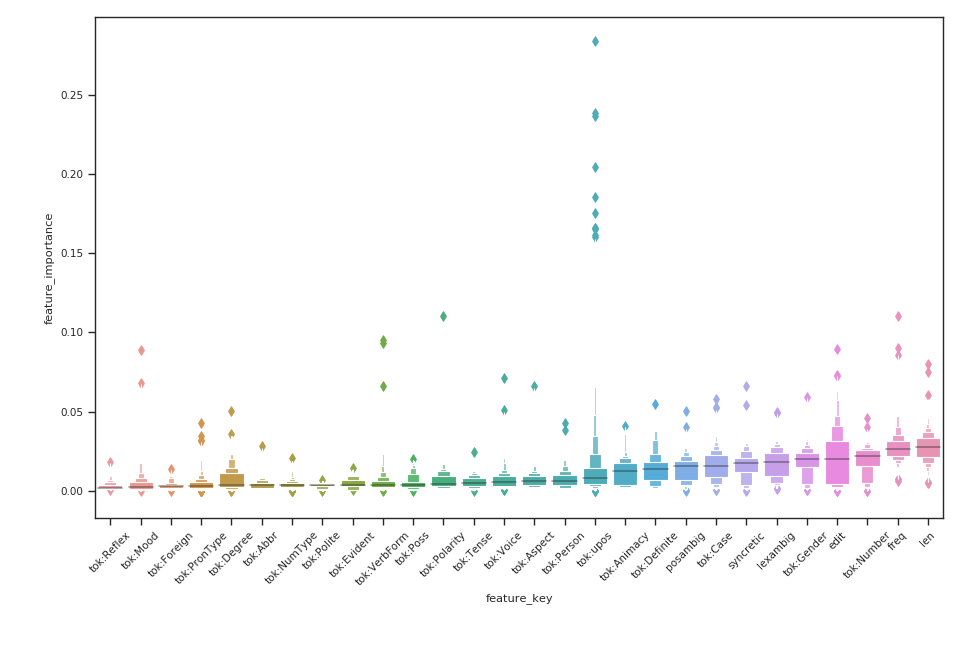

In [346]:
medians = {}
for feat in good_feat_conll2018["feature_key"].unique():
    feat_score = good_feat_conll2018[good_feat_conll2018["feature_key"] == feat]["feature_importance"]
    if not feat_score.empty:
        medians[feat] = feat_score.median()
    
sns.boxenplot(
    data=good_feat_conll2018,
    x="feature_key",
    y="feature_importance",
    order=sorted(medians.keys(), key=lambda x: medians[x])#[-15:]
)
plt.xticks(rotation=45)
plt.tight_layout()

Looks almost exactly the same as the regular plot :< :< :< :< :<

## Feature frequency

<IPython.core.display.Javascript object>


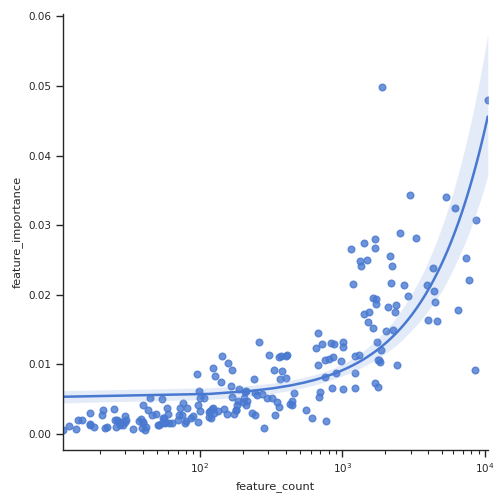

In [42]:
ax = sns.lmplot(
    data=feat_conll2018.groupby("feature_name").mean(),
    x="feature_count",
    y="feature_importance",
    legend_out=True,
    logx=False,
)
plt.tight_layout()
plt.gca().set_xscale("log")

There is pretty good **linear** (note the log-scale) correlation between average feature count and average feature importance.

In a single number:

In [43]:
# Pearson correlation
feat_conll2018.groupby("feature_name").mean().corr(method="pearson").loc["feature_count"].loc["feature_importance"]


0.7260578607017336

# Morphological complexity

In [128]:
pg.pairwise_corr(
    data=stats,
    columns=[["clf_f1"],
             ["ttr", "msp", "pos_ent", "pos_types", 
              "feat_ent", "feat_types", "cent_form_feat", "cent_feat_form"]]
)

,X,Y,method,tail,n,r,CI95%,r2,adj_r2,z,p-unc,BF10,power
0,clf_f1,ttr,pearson,two-sided,2283,-0.027,"[-0.07, 0.01]",0.001,-0.000,-0.027,1.978287e-01,0.06,0.251
1,clf_f1,msp,pearson,two-sided,2283,0.097,"[0.06, 0.14]",0.009,0.008,0.097,3.794666e-06,1135.676,0.996
2,clf_f1,pos_ent,pearson,two-sided,2283,-0.135,"[-0.17, -0.09]",0.018,0.017,-0.136,9.568154e-11,3.258e+07,1.000
3,clf_f1,pos_types,pearson,two-sided,2283,-0.130,"[-0.17, -0.09]",0.017,0.016,-0.131,3.890077e-10,8.284e+06,1.000
4,clf_f1,feat_ent,pearson,two-sided,2283,0.055,"[0.01, 0.1]",0.003,0.002,0.055,8.591718e-03,0.827,0.748
5,clf_f1,feat_types,pearson,two-sided,2283,0.049,"[0.01, 0.09]",0.002,0.002,0.049,1.821612e-02,0.425,0.656
6,clf_f1,cent_form_feat,pearson,two-sided,2283,0.019,"[-0.02, 0.06]",0.000,-0.000,0.019,3.530406e-01,0.04,0.153
7,clf_f1,cent_feat_form,pearson,two-sided,2283,0.137,"[0.1, 0.18]",0.019,0.018,0.138,4.987857e-11,6.158e+07,1.000


In [129]:
pg.pairwise_corr(
    data=stats,
    columns=[["clf_f1"],
             ["ttr", "msp", "pos_ent", "pos_types", 
              "feat_ent", "feat_types", "cent_form_feat", "cent_feat_form"]],
    covar="bor"
)

,X,Y,method,covar,tail,n,r,CI95%,r2,adj_r2,z,p-unc,BF10,power
0,clf_f1,ttr,pearson,['bor'],two-sided,2283,-0.022,"[-0.06, 0.02]",0.000,-0.000,-0.022,2.960404e-01,0.045,0.181
1,clf_f1,msp,pearson,['bor'],two-sided,2283,-0.125,"[-0.17, -0.08]",0.016,0.015,-0.126,2.095018e-09,1.605e+06,1.000
2,clf_f1,pos_ent,pearson,['bor'],two-sided,2283,0.136,"[0.1, 0.18]",0.019,0.018,0.137,6.054319e-11,5.095e+07,1.000
3,clf_f1,pos_types,pearson,['bor'],two-sided,2283,0.135,"[0.09, 0.17]",0.018,0.017,0.136,1.026620e-10,3.041e+07,1.000
4,clf_f1,feat_ent,pearson,['bor'],two-sided,2283,0.348,"[0.31, 0.38]",0.121,0.120,0.363,5.664760e-66,1.948e+62,1.000
5,clf_f1,feat_types,pearson,['bor'],two-sided,2283,0.345,"[0.31, 0.38]",0.119,0.118,0.360,1.103172e-64,1.012e+61,1.000
6,clf_f1,cent_form_feat,pearson,['bor'],two-sided,2283,0.052,"[0.01, 0.09]",0.003,0.002,0.052,1.283892e-02,0.578,0.702
7,clf_f1,cent_feat_form,pearson,['bor'],two-sided,2283,-0.137,"[-0.18, -0.1]",0.019,0.018,-0.138,4.183387e-11,7.314e+07,1.000


In [130]:
pg.pairwise_corr(
    data=stats,
    columns=[["clf_mcc"],
             ["ttr", "msp", "pos_ent", "pos_types", 
              "feat_ent", "feat_types", "cent_form_feat", "cent_feat_form"]]
)

,X,Y,method,tail,n,r,CI95%,r2,adj_r2,z,p-unc,BF10,power
0,clf_mcc,ttr,pearson,two-sided,2283,-0.016,"[-0.06, 0.03]",0.000,-0.001,-0.016,4.560495e-01,0.035,0.116
1,clf_mcc,msp,pearson,two-sided,2283,-0.100,"[-0.14, -0.06]",0.010,0.009,-0.100,1.575487e-06,2639.345,0.998
2,clf_mcc,pos_ent,pearson,two-sided,2283,0.133,"[0.09, 0.17]",0.018,0.017,0.134,1.797074e-10,1.76e+07,1.000
3,clf_mcc,pos_types,pearson,two-sided,2283,0.127,"[0.09, 0.17]",0.016,0.015,0.128,1.094263e-09,3.022e+06,1.000
4,clf_mcc,feat_ent,pearson,two-sided,2283,0.443,"[0.41, 0.48]",0.196,0.195,0.476,3.244120e-110,2.449e+106,1.000
5,clf_mcc,feat_types,pearson,two-sided,2283,0.432,"[0.4, 0.46]",0.186,0.186,0.462,2.498552e-104,3.299e+100,1.000
6,clf_mcc,cent_form_feat,pearson,two-sided,2283,0.014,"[-0.03, 0.06]",0.000,-0.001,0.014,4.934665e-01,0.033,0.105
7,clf_mcc,cent_feat_form,pearson,two-sided,2283,-0.091,"[-0.13, -0.05]",0.008,0.007,-0.091,1.355258e-05,336.431,0.992


<IPython.core.display.Javascript object>


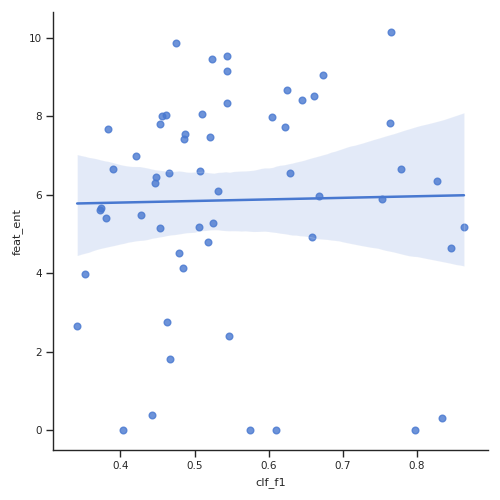

In [142]:
ax = sns.lmplot(
    data=stats.groupby("language").mean(),
    x="clf_f1",
    y="feat_ent",
    legend_out=True,
)
plt.tight_layout()

<IPython.core.display.Javascript object>


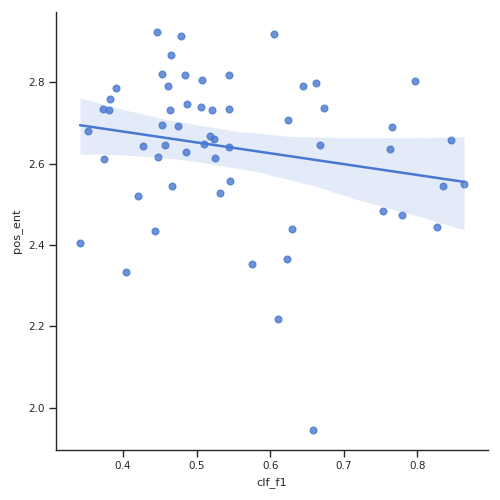

In [141]:
ax = sns.lmplot(
    data=stats.groupby("language").mean(),
    x="clf_f1",
    y="pos_ent",
    legend_out=True,
)
plt.tight_layout()

In [140]:
pg.pairwise_corr(
    data=stats,#.groupby("language").median(),
    columns=[["diff_f1_morph_nomorph"],
             ["ttr", "msp", "pos_ent", "pos_types", 
              "feat_ent", "feat_types", "cent_form_feat", "cent_feat_form"]],
    #covar="bor"
)

,X,Y,method,tail,n,r,CI95%,r2,adj_r2,z,p-unc,BF10,power
0,diff_f1_morph_nomorph,ttr,pearson,two-sided,2283,0.044,"[0.0, 0.09]",0.002,0.001,0.044,3.476762e-02,0.243,0.560
1,diff_f1_morph_nomorph,msp,pearson,two-sided,2283,-0.136,"[-0.18, -0.1]",0.018,0.018,-0.137,7.114329e-11,4.352e+07,1.000
2,diff_f1_morph_nomorph,pos_ent,pearson,two-sided,2283,0.348,"[0.31, 0.38]",0.121,0.120,0.363,4.886348e-66,2.257e+62,1.000
3,diff_f1_morph_nomorph,pos_types,pearson,two-sided,2283,0.342,"[0.3, 0.38]",0.117,0.116,0.356,1.808297e-63,6.247e+59,1.000
4,diff_f1_morph_nomorph,feat_ent,pearson,two-sided,2283,0.426,"[0.39, 0.46]",0.181,0.181,0.455,3.444751e-101,2.442e+97,1.000
5,diff_f1_morph_nomorph,feat_types,pearson,two-sided,2283,0.416,"[0.38, 0.45]",0.173,0.172,0.443,3.401350e-96,2.557e+92,1.000
6,diff_f1_morph_nomorph,cent_form_feat,pearson,two-sided,2283,-0.025,"[-0.07, 0.02]",0.001,-0.000,-0.025,2.381234e-01,0.053,0.218
7,diff_f1_morph_nomorph,cent_feat_form,pearson,two-sided,2283,-0.160,"[-0.2, -0.12]",0.026,0.025,-0.161,1.249106e-14,2.097e+11,1.000


<IPython.core.display.Javascript object>


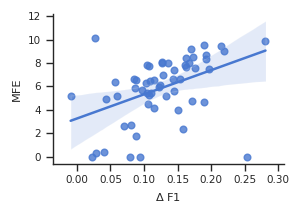

In [143]:
sns.set_context("paper", font_scale=.85)
sns.set_style("ticks")
sns.set_palette("muted")
plt.figure(figsize=(3.02, 2.15))

ax = sns.regplot(
    data=stats.groupby("language").median(),
    x="diff_f1_morph_nomorph",
    y="feat_ent",
    #legend_out=True,
)
plt.tight_layout()

#plt.xlim(-.5,56.5)
#plt.ylim(-1,11)
#plt.xticks(rotation=90)
g = plt.gca()
g.set_xlabel(r"$\Delta$ F1")
g.set_ylabel(r"MFE")
sns.despine()
plt.tight_layout()
if True:
    plt.savefig('plots/fscore_delta_corr_mfe.pgf', bbox_inches='tight')

<IPython.core.display.Javascript object>


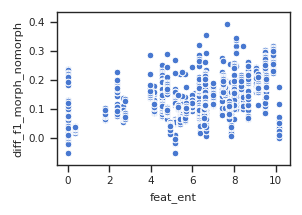

In [144]:
sns.set_context("paper", font_scale=.85)
sns.set_style("ticks")
sns.set_palette("muted")
plt.figure(figsize=(3.02, 2.15))
_d = stats_with_mlc[stats["dataset"] == "conll2018"]
sns.scatterplot(_d["feat_ent"], _d["diff_f1_morph_nomorph"],
                #hue=stats["dataset"],
                #style=stats["dataset"],
                #alpha=0.6
               )
g = plt.gca()
#g.set_ylabel("F1 score")
#g.set_xlabel("Frequency of error label")

plt.tight_layout()


In [145]:
_data = stats[stats["dataset"] == "conll2018"]
_mfe = _data.groupby("alpha_3")["feat_ent"].first()#.reset_index()
_order = _data.groupby("alpha_3")["diff_f1_morph_nomorph"].median().sort_values()
_data = _order.reset_index().join(_mfe, on="alpha_3")

<IPython.core.display.Javascript object>


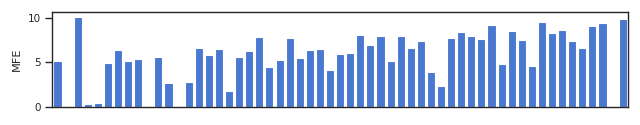

In [146]:
sns.set_context("paper", font_scale=.85)
plt.figure(figsize=(6.4, 1.25))
plt.bar(
    x=list(range(57)),
    height=_data["feat_ent"]
)

plt.xlim(-.5,56.5)
#plt.xticks(rotation=90)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
g = plt.gca()
g.set_ylabel(r"MFE")
#g.set_xlabel("Language")
plt.tight_layout()
if True:
    plt.savefig('plots/fscore_delta_by_lang_mfe.pgf', bbox_inches='tight')

<IPython.core.display.Javascript object>


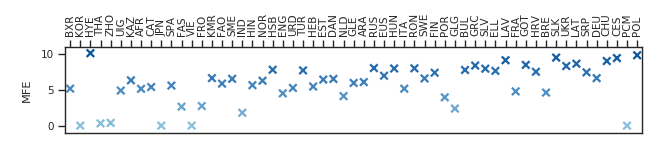

In [213]:
# copy-pasta
_data = stats_conll2018
_mfe = _data.groupby("alpha_3")["feat_ent"].first()#.reset_index()
_order = _data.groupby("alpha_3")["diff_f1_morph_nomorph"].median().sort_values()
_data = _order.reset_index().join(_mfe, on="alpha_3")

_blues = sns.color_palette("Blues")
_cmap = sns.blend_palette([_blues[2], _blues[-1]], as_cmap=True)

mfe_sorted = sorted(
    stats_conll2018["alpha_3"].unique(),
    key=lambda x: stats_conll2018.groupby("alpha_3")["diff_f1_morph_nomorph"].median().loc[x].item()
)
_urgh = stats_conll2018.set_index("alpha_3").loc[mfe_sorted]["feat_ent"]
mfe_sorted = [_urgh[x][0] for x in mfe_sorted]
mfe_min = min(mfe_sorted)
mfe_max = max(mfe_sorted)

_colors = [_cmap((x - mfe_min) / mfe_max) 
           if not np.isnan(x)
           else (0.7,0.7,0.7,1.0)
           for x in mfe_sorted]
########################

sns.set_context("paper", font_scale=.85)
plt.figure(figsize=(6.55, 1.45))
sns.pointplot(
    data=_data,
    x="alpha_3",
    y="feat_ent",
    linestyles="",
    markers="x",
    palette=_colors
)

#plt.xlim(-.5,56.5)
plt.ylim(-1,11)
#plt.tick_params(
#    axis='x',          # changes apply to the x-axis
#    which='both',      # both major and minor ticks are affected
#    bottom=False,      # ticks along the bottom edge are off
#    top=False,         # ticks along the top edge are off
#    labelbottom=False) # labels along the bottom edge are off
g = plt.gca()
g.xaxis.tick_top()
plt.xticks(rotation=90)
g.set_ylabel(r"MFE", labelpad=6)
g.set_xlabel(None)
plt.tight_layout()
if True:
    plt.savefig('plots/fscore_delta_by_lang_mfe.pgf', bbox_inches='tight')

<IPython.core.display.Javascript object>


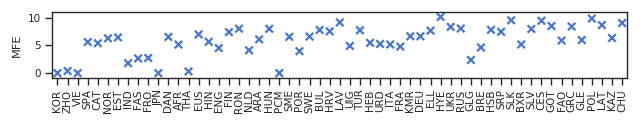

In [148]:
_data = stats[stats["dataset"] == "conll2018"]
_mfe = _data.groupby("alpha_3")["feat_ent"].first()#.reset_index()
_order = _data.groupby("alpha_3")["clf_mcc"].median().sort_values()
_data = _order.reset_index().join(_mfe, on="alpha_3")
sns.set_context("paper", font_scale=.85)
plt.figure(figsize=(6.4, 1.25))
sns.pointplot(
    data=_data,
    x="alpha_3",
    y="feat_ent",
    linestyles="",
    markers="x",
)

plt.xticks(rotation=90)
g = plt.gca()
g.set_ylabel(r"MFE")
g.set_xlabel(None)
plt.tight_layout()
#if True:
#    plt.savefig('plots/mcc_by_lang_mfe.pgf', bbox_inches='tight')

In [149]:
_data = stats[stats["dataset"] == "conll2018"]
_mfe = _data.groupby("alpha_3")["feat_ent"].first()#.reset_index()
_order = _data.groupby("alpha_3")["clf_f1_by_bor"].median().sort_values()
_data = _order.reset_index().join(_mfe, on="alpha_3")

<IPython.core.display.Javascript object>


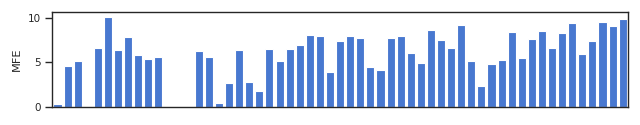

In [150]:
sns.set_context("paper", font_scale=.85)
plt.figure(figsize=(6.4, 1.25))
plt.bar(
    x=list(range(57)),
    height=_data["feat_ent"]
)

plt.xlim(-.5,56.5)
#plt.xticks(rotation=90)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
g = plt.gca()
g.set_ylabel(r"MFE")
#g.set_xlabel("Language")
plt.tight_layout()

In [151]:
stats[stats["language"] == "Armenian"]["diff_f1_morph_nomorph"].mean()

0.038327999999999994

In [152]:
stats["feat_ent"].max()

10.151433836416377

In [181]:
# Can we get a full results table?!

table = stats.groupby(["dataset_latex", "alpha_3", "language"], as_index=False)[["bor", "feat_ent", "clf_f1", "diff_f1_morph_nomorph"]].mean()
print(table.set_index("dataset_latex").to_latex(float_format="%.2f"))


\begin{tabular}{lllrrrr}
\toprule
{} & alpha\_3 &                   language &  bor &  feat\_ent &  clf\_f1 &  diff\_f1\_morph\_nomorph \\
dataset\_latex  &         &                            &      &           &         &                        \\
\midrule
\textbackslash taskPARSEME\{\} &     ELL &       Modern Greek (1453-) & 0.01 &      7.68 &    0.16 &                   0.11 \\
\textbackslash taskPARSEME\{\} &     ENG &                    English & 0.06 &      4.52 &    0.25 &                   0.11 \\
\textbackslash taskPARSEME\{\} &     EUS &                     Basque & 0.03 &      6.99 &    0.25 &                   0.15 \\
\textbackslash taskPARSEME\{\} &     FAS &                    Persian & 0.03 &      2.66 &    0.18 &                   0.09 \\
\textbackslash taskPARSEME\{\} &     HEB &                     Hebrew & 0.01 &      5.48 &    0.08 &                   0.05 \\
\textbackslash taskPARSEME\{\} &     HUN &                  Hungarian & 0.10 &      8.01 &    0.22 &     

In [172]:
stats.columns

Index(['dataset', 'file', 'clf_acc_nomorph', 'clf_f1_nomorph',
       'clf_mcc_nomorph', 'clf_kappa_nomorph', 'diff_acc_nomorph',
       'diff_f1_nomorph', 'language_nomorph', 'clf_acc', 'clf_f1', 'clf_mcc',
       'clf_kappa', 'diff_acc', 'diff_f1', 'language', 'ttrstats', 'bor',
       'feats', 'ftr', 'train_sents', 'train_toks', 'diff_f1_morph_nomorph',
       'clf_f1_by_bor', 'alpha_3', 'dataset_latex', 'fname', 'ttr', 'ttr_sd',
       'msp', 'msp_sd', 'pos_ent', 'pos_ent_sd', 'pos_types', 'pos_types_sd',
       'feat_ent', 'feat_ent_sd', 'feat_types', 'feat_types_sd',
       'cent_form_feat', 'cent_form_feat_sd', 'cent_feat_form',
       'cent_feat_form_sd'],
      dtype='object')